# Model

### imports

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np

import mnist

from sklearn.cluster import MiniBatchKMeans
from skimage.util import view_as_windows

import matplotlib.lines as mlines

from scipy.sparse import csr_matrix

### Model definition

#### Utils

In [3]:
#same padding
def to_windows(img,window_shape,step_shape,dims=None):
    pad = []
    if dims is None : dims = img.ndim
    # for all channels (multi dim support)
    for i in range(img.ndim):
        if i < dims:
            n = img.shape[i]
            s = step_shape[i]
            f = window_shape[i]
            p = int((f + (n - 1)*s - n)/2) # compute encessary padding for same padding
        else:
            p = 0
        pad.append((p,p))
    # pah has necessary padding for each axis at this point
    img_padded = np.pad(img, tuple(pad), 'constant', constant_values=(0)) # apply paddings
    output = view_as_windows(img_padded,window_shape,step_shape) # slide windows across image and save contents (padded image)
    output = output.reshape( -1, np.prod( window_shape ) ) # 28*28*5*5 -> 784*25
    return output

# heviside of matrix
def H(x):
    y = np.zeros(x.shape) 
    y[x>0] = 1
    return y

#### Cosine convolution and Membership function

In [4]:
# outro paper... nao usar (maybe)
def regular_convolution(x,K):
    kernel_shape = K.shape
    step_shape = tuple(np.ones(len(kernel_shape)).astype(int))
    data = to_windows(x,kernel_shape,step_shape)
    W = K.reshape(1,-1)
    logits = data @ W.T
    return logits.reshape(x.shape)

# esta foi usada no paper (quase de certeza)
def cosine_convolution(x,K,wta=True):    # TODO: falta o W como argumnto
    k = K.shape[0]
    kernel_shape = K.shape[1:]
    step_shape = tuple(np.ones(len(kernel_shape)).astype(int))
    data = to_windows(x,kernel_shape,step_shape)
    norms = np.linalg.norm(data,axis=1,keepdims=True)
    out = (norms<=0)[:,0]
    norms[out] = 1
    data = data / norms
    W = K.reshape(k,-1)
    norms = np.linalg.norm(W,axis=1,keepdims=True)
    W = W / norms
    d = ((data @ W.T) + 1)/2 # @ is matrix mul TODO: ver o que é este +1 /2
    if wta:
        t = d.max(axis=1,keepdims=True) # para cada window da imagem selecionar a mais similar
        t[np.linalg.norm(data,axis=1)<=0] = np.inf
        o = np.zeros(d.shape)
        o[(t-d)<=0] = d[(t-d)<=0]
        o = o.reshape(x.shape + (k,)) # imagem 28*28*K(num features)
        return o
    return d.reshape(x.shape + (k,)) 

# tb posso usar esta
def euclid_convolution(x,km,wta=True):  #km== objecto que contem o resultado do k-means 
    k = km.cluster_centers_.shape[0] # resultado dos centroids
    kernel_shape = int(np.sqrt(km.cluster_centers_.shape[1]))
    kernel_shape = (kernel_shape,kernel_shape)
    step_shape = tuple(np.ones(len(kernel_shape)).astype(int))
    data = to_windows(x,kernel_shape,step_shape)
    d = 1/km.transform(data) # transform calcula distancia aos centroids
    if wta:
        t = d.max(axis=1,keepdims=True)
        t[np.linalg.norm(data,axis=1)<=0] = np.inf
        o = np.zeros(d.shape)
        o[(t-d)<=0] = d[(t-d)<=0]
        o = o.reshape(x.shape + (k,))
        return o
    return d.reshape(x.shape + (k,))

In [5]:
def mu_ret(img,K,T_ret,wta=True): # recebe imagem, k(n features) e threshold e calcula a convolution e 
    z = cosine_convolution(img,K,wta=wta)
    #z = euclid_convolution(img,K,wta=wta)
    a = H(z - np.quantile(z[z>0],q=T_ret))
    return a

#### Set enumeration and Geometric transformations

In [6]:
def enum_set(a):
    n_H, n_W, n_K = a.shape
    k = np.linspace(1, n_K, n_K)
    h = np.flip(np.linspace(0, n_H-1, n_H))
    w = np.linspace(0, n_W-1, n_W)
    W, H, K = np.meshgrid(w, h, k)
    k = K[a!=0]
    h = H[a!=0]
    w = W[a!=0]
    ret_set = np.zeros((k.shape[0],3))
    ret_set[:,0] = ((w/(n_W-1))*2)-1
    ret_set[:,1] = ((h/(n_H-1))*2)-1
    ret_set[:,2] = k
    return ret_set # 3 colunas: pos em x pos em y, feature q ganhou

def translation(features,C_x,C_y):
    M = np.eye(3)
    M[0:-1,-1] = (C_x,C_y)
    pos = np.copy(features)
    pos[:,-1] = 1
    pos = np.dot(M,pos.T).T
    pos[:,-1] = features[:,-1]
    return pos

def scale(features,rad):
    pos = np.copy(features)
    M = np.diag([1./rad,1./rad])
    pos[:,0:2] = np.dot(M,pos[:,0:2].T).T
    return pos
    
def rotation(features,theta): # nao usado no paper
    pos = np.copy(features)
    M = np.array([[np.cos(theta),-np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    pos[:,0:2] = np.dot(M,pos[:,0:2].T).T
    return pos

def polar_transform(x):
    cx,cy = np.mean(x[:,0:2],axis=0)
    w = x[:,0]
    h = x[:,1]
    rad = np.max(np.sqrt((w - cx)**2 + (h - cy)**2))
    pol = scale(translation(x,-cx,-cy),rad)
    return pol

#### Grid encoding

In [7]:
def grid_encoding(x,Q,k):
    pol = np.zeros(x.shape)
    pol[:,0] = x[:,1]
    pol[:,1] = x[:,0]
    pol[:,2] = x[:,2]
    h = np.histogramdd(pol, bins=(Q,Q,k), range=[(-1,1),(-1,1),(1,k)])[0] # conta para cada posi da grelha qnts pontos estao la dentro
    h = np.flip(h,axis=0) # for visualization purposes y axist pointing down
    h[h>0] = 1 # transofrma histograma em binary [0,1,2] -> [0,1,1]
    return h

#### Dictionary learning

In [8]:
"""
D conjunto de treino
K num features
patch_size: tamnaho da window 
background :  minimum windows norm
 """
def learn_dictionary(D,k,patch_size,rng,n_epochs,background=0.8,kmeans=None):
    print('Learning the dictionary... ')
    if kmeans is None:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=rng, verbose=True)
    buffer = []
    t0 = time.time()
    index = 0
    for _ in range(n_epochs):
        for img in D:
            data = to_windows(img,patch_size,tuple(np.ones(len(patch_size)).astype(int)))
            norms = np.linalg.norm(data,axis=1,keepdims=True)
            keep = norms>background
            keep = keep[:,0]
            data = data[keep,:]
            #norms = norms[keep,:]
            #data = data / norms
            data = np.reshape(data, (len(data), -1))
            buffer.append(data)
            index += 1
            if index % 10 == 0:
                data = np.concatenate(buffer, axis=0)
                #data -= np.mean(data, axis=0)
                #data /= np.std(data, axis=0)
                kmeans.partial_fit(data)
                buffer = []
            if index % 100 == 0:
                print('Partial fit of %4i out of %i'% (index, n_epochs * len(D)))
    dt = time.time() - t0
    print('done in %.2fs.' % dt)
    return kmeans.cluster_centers_.reshape((-1,) + patch_size),kmeans

#### Plotting functions

In [9]:
def plot_dict(W,patch_size):
    plt.figure(figsize=(4.2, 4))
    for i, patch in enumerate(W):
        plt.subplot(9, 9, i + 1)
        plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray,
                   interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    plt.show()

### Experiments

Shape: (60000, 28, 28)
Example: 


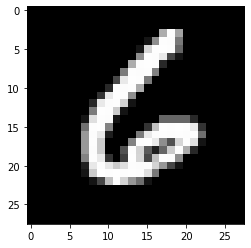

In [10]:
D = mnist.train_images()/255.
y_D = mnist.train_labels()
T = mnist.test_images()/255.
y_T = mnist.test_labels()
print("Shape: " + str(D.shape))
print("Example: ")
plt.imshow(D[np.random.permutation(D.shape[0])[0]],cmap="gray")
plt.show()

#### 0) Baseline run

In [11]:
n_epochs = 5
rng = np.random.RandomState(0)
k = 30 # aumaentar isto para ter mais sparsity
kernel_shape = (5,5)
T_what = 0.6 # subir isto para ficar mais sparse
Q = 18 # aumentar a grelha para msi sparsity
wta = True


In [12]:
K,km = learn_dictionary(D,k,kernel_shape,rng,n_epochs,background=0.8)

00
Partial fit of 244600 out of 300000
Partial fit of 244700 out of 300000
Partial fit of 244800 out of 300000
Partial fit of 244900 out of 300000
Partial fit of 245000 out of 300000
Partial fit of 245100 out of 300000
Partial fit of 245200 out of 300000
Partial fit of 245300 out of 300000
Partial fit of 245400 out of 300000
Partial fit of 245500 out of 300000
Partial fit of 245600 out of 300000
Partial fit of 245700 out of 300000
Partial fit of 245800 out of 300000
Partial fit of 245900 out of 300000
Partial fit of 246000 out of 300000
Partial fit of 246100 out of 300000
Partial fit of 246200 out of 300000
Partial fit of 246300 out of 300000
Partial fit of 246400 out of 300000
Partial fit of 246500 out of 300000
Partial fit of 246600 out of 300000
Partial fit of 246700 out of 300000
Partial fit of 246800 out of 300000
Partial fit of 246900 out of 300000
Partial fit of 247000 out of 300000
Partial fit of 247100 out of 300000
Partial fit of 247200 out of 300000
Partial fit of 247300 out

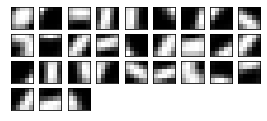

In [12]:
plot_dict(K,kernel_shape)

In [13]:
X_trn = np.zeros((D.shape[0],k*Q**2))
for i in range(D.shape[0]):
    if i % 10000 == 0:
        print(i)
    img = D[i]
    a = mu_ret(img,km,T_what,wta=True)
    s = enum_set(a)
    p = polar_transform(s)
    e = grid_encoding(p,Q,K.shape[0])
    X_trn[i] = e.flatten()
X_trn = csr_matrix(X_trn) # guardar como matrix esparsa

0


AttributeError: 'MiniBatchKMeans' object has no attribute 'shape'

In [29]:
X_tst = np.zeros((T.shape[0],k*Q**2))
for i in range(T.shape[0]):
    if i % 1000 == 0:
        print(i)
    img = T[i]
    a = mu_ret(img,km,T_what,wta=True)
    s = enum_set(a)
    p = polar_transform(s)
    e = grid_encoding(p,Q,K.shape[0])
    X_tst[i,:] = e.flatten()
X_tst = csr_matrix(X_tst)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
